In [ ]:
#hide
#all_slow

# Using this module as a BIDS app

This app allows you to train and validate voxel-wise encoding models for a BIDS dataset with a BIDS-compliant stimulus representation. See below for an example on how to use it.
To specify parameters for the processing of the stimulus (e.g. lagging and offsetting relative to fMRI), you can specify parameters that are supplied to `make_X_Y` in the `preprocessing` module as a JSON file. Similarly you can specify parameters to be supplied to `get_ridge_plus_scores` in the `encoding` module as a JSON as well.
Masking is done by default, by checking for masks in `output_dir/masks/` that are either named `sub-PARTICIPANT_LABEL_mask.nii.gz` (where PARTICIPANT_LABEL is the label provided by the user) or that are named `group_mask.nii.gz`. To disable masking call with the lag `--no-masking`.
Voxel-encoding models are trained in a cross-validation scheme: the parameter `cv` that is supplied to `get_ridge_plus_scores` via a configuation JSON file determines the number of folds in the cross-validation. Each fold is left out once, while a model is trained (and hyperparameters are tuned) on the remaining folds - model validation is done by voxel-wise [product moment correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predicted and observed fMRI activity for the left-out fold and saved as a 4D nifti in the output folder (with one image per left-out fold).
Similarly, for each left-out fold, Ridge regression models (trained on the remaining folds) are saved as a pickle file in the output folder.


This shows how to (for a BIDS compliant dataset) extract features, save them in BIDS format, and run a BIDS app for voxel-wise encoding models.
We are going to use [this](https://openneuro.org/datasets/ds002322/versions/1.0.4) dataset.

#### *Warning*: Executing this notebook will download the full dataset.

In [ ]:
!aws s3 sync --no-sign-request s3://openneuro.org/ds002322 ds002322-download/

## Extracting a stimulus representation

The dataset in question consists of fMRI activity recorded of several participants while they listened to a reading of the first chapter of Lewis Carroll’s Alice in Wonderland.
First we want to extract a stimulus representation that we can use - I chose a Mel spectrogram for demonstration.
[This](https://github.com/mjboos/audio2bidsstim/) small Python script extracts such a representation and saves it in a BIDS compliant format.

If you get an error that `sndfile library` was not found, you will need to use conda to install it.

In [1]:
import json
# these are the parameters for extracting a Mel spectrogram
# for computational ease in this example we want 1 sec segments of 31 Mel frequencies with a max frequency of * KHz
mel_params = {'n_mels': 31, 'sr': 16000, 'hop_length': 16000, 'n_fft': 16000, 'fmax': 8000}
with open('config.json', 'w+') as fl:
    json.dump(mel_params, fl)

#!git clone https://github.com/mjboos/audio2bidsstim/
#!pip install -r audio2bidsstim/requirements.txt
!python audio2bidsstim/wav_files_to_bids_tsv.py ds002322-download/stimuli/DownTheRabbitHoleFinal_mono_exp120_NR16_pad.wav -c config.json
!ls -l

total 552
drwxrwxrwx  3 mwitte users   4096 Mär  6 17:24 audio2bidsstim
drwxrwxrwx  2 mwitte users   4096 Mär  6 17:08 boutiques
-rwxrwxrwx  1 mwitte users     78 Mär  6 17:30 config.json
-rwxrwxrwx  1 mwitte users   1684 Mär  5 18:35 Dockerfile
drwxrwxrwx 11 mwitte users   4096 Mär  6 17:08 docs
-rwxrwxrwx  1 mwitte users    696 Mär  6 17:31 DownTheRabbitHoleFinal_mono_exp120_NR16_pad.json
-rwxrwxrwx  1 mwitte users 227110 Mär  6 17:31 DownTheRabbitHoleFinal_mono_exp120_NR16_pad.tsv.gz
drwxrwxrwx 32 mwitte users   4096 Mär  6 17:26 ds002322-download
-rwxrwxrwx  1 mwitte users  26607 Mär  5 18:35 encoding.ipynb
-rwxrwxrwx  1 mwitte users   1374 Mär  5 18:35 git-set-file-times
-rwxrwxrwx  1 mwitte users  69623 Mär  5 18:35 index.ipynb
-rwxrwxrwx  1 mwitte users  11357 Mär  5 18:35 LICENSE
-rwxrwxrwx  1 mwitte users   1054 Mär  5 18:35 LICENSE.txt
-rwxrwxrwx  1 mwitte users    478 Mär  5 18:35 Makefile
-rwxrwxrwx  1 mwitte users    111 Mär  5 18:35 MANIFEST.in
-rwxrwxrwx  1 mwitte users 

Now we must copy these files into the BIDS dataset directory according to [these](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/06-physiological-and-other-continuous-recordings.html) specifications.
We are going to use the `derivatives` folder for the already preprocessed data.

In [2]:
!cp DownTheRabbitHoleFinal_mono_exp120_NR16_pad.tsv.gz ds002322-download/derivatives/task-alice_stim.tsv.gz
!cp DownTheRabbitHoleFinal_mono_exp120_NR16_pad.json ds002322-download/derivatives/sub-24/sub-24_task-alice_stim.json

And, lastly, because for this dataset the derivatives folder is missing timing information for the BOLD files - we are only interested in the TR - we have to copy that as well.

In [3]:
!cp ds002322-download/sub-24/sub-24_task-alice_bold.json ds002322-download/derivatives/sub-24/sub-24_task-alice_bold.json 

## Running the analysis

Now we're all set and can run our encoding analysis. This analysis uses standard Ridge regression, and we're going to specify some additional parameters here.

In [4]:
ridge_params = {'alphas': [1e-1, 1, 100, 1000], 'cv': 3, 'normalize': True}

# and for lagging the stimulus as well - we want to include 6 sec stimulus segments to predict fMRI
lagging_params = {'lag_time': 6}
with open('encoding_config.json', 'w+') as fl:
    json.dump(ridge_params, fl)
    
with open('lagging_config.json', 'w+') as fl:
    json.dump(lagging_params, fl)


Now we just need [this](https://github.com/mjboos/voxelwiseencoding) BIDS app for running the analysis.
Running this cell will fit voxel-wise encoding models, which right now need about 8 Gig of RAM. 

### Using Docker to run the voxelwise-encoding BIDS app

You can use Docker to build/get an image that already includes all libraries:

In [ ]:
#!git clone https://github.com/mjboos/voxelwiseencoding
#!mkdir output
# we need to mount a config folder for our json files
#!mkdir config
#!cp *config.json config/
#!docker run -i --rm -v ds002322-download/derivatives:bids_dataset/:ro -v config/:/config:ro -v output/:/output mjboos/voxelwiseencoding /bids_dataset /output --task alice --skip_bids_validator --participant_label 18 --preprocessing-config /config/lagging_config.json --encoding-config /config/encoding_config.json --detrend --standardize zscore 

### Alternative: run the module directly

Alternatively you can install the required libraries directly and run the Python script yourself.

In [7]:
#!git clone https://github.com/mjboos/voxelwiseencoding
#!pip install -r voxelwiseencoding/requirements.txt
#!mkdir output/sub-24
!python run.py ds002322-download/derivatives output/sub-24 --task alice --skip_bids_validator --participant_label 24 --preprocessing-config lagging_config.json --encoding-config encoding_config.json --detrend --standardize zscore 

Traceback (most recent call last):
  File "run.py", line 119, in <module>
    encoding_kwargs=encoding_kwargs, **vars(args))
  File "/data2/azubaidi/github/voxelwiseencoding/voxelwiseencoding/process_bids.py", line 252, in run_model_for_subject
    **encoding_kwargs)
  File "/data2/azubaidi/github/voxelwiseencoding/voxelwiseencoding/encoding.py", line 88, in get_model_plus_scores
    bold_prediction = np.concatenate(bold_prediction, axis=-1)
  File "<__array_function__ internals>", line 6, in concatenate
ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 124 and the array at index 1 has size 123


Now we'll have some ridge regressions saved in output, as well as scores saved as a Nifti file - which we can visualize.
First we load the scores - we have one volume containing the scores per fold - and average them and then plot them via Nilearn.

In [5]:
from nilearn.image import load_img
size_scores = load_img('output/sub-24/sub-24_task-alice_scores.nii.gz')

print(size_scores.shape)


size_bold_raw = load_img('/data2/azubaidi/github/voxelwiseencoding/ds002322-download/derivatives/sub-24/sub-24_task-alice_bold_preprocessed.nii.gz')

print(size_bold_raw.shape)


#https://docs.python.org/3/library/pickle.html

#import pickle

#with open('output/sub-24/sub-24_task-alice_bold_prediction.pkl', 'rb') as p_f:
   # data = pickle.load(p_f)
    
import joblib
bold_prediction_list = joblib.load('output/sub-24/sub-24_task-alice_bold_prediction.pkl')
#print(len(bold_prediction_list))  # number of list 
#print(bold_prediction_list.shape)


#print(*bold_prediction_list)


#import pickle
#import pandas as pd
#df=pd.read_pickle('output/sub-24/sub-24_task-alice_bold_prediction.pkl')
#print(df)
# df_new=df[df["y"].notnull()]
#print(df.y.shape)

#import pickle
#inf = pickle.load(open('output/sub-24/sub-24_task-alice_bold_prediction.pkl', 'r'))
#print(inf.X.shape)
#print(inf.y.shape)


import numpy as np
bold_prediction = np.concatenate(bold_prediction_list, axis=0)
print(bold_prediction.shape)


from nibabel import save
save(scores_bold, os.path.join(args.output_dir, '{0}_{1}scores.nii.gz'.format(filename_output, identifier)))

#import pandas as pd
#size_bold_prediction =pd.read_pickle("output/sub-24/sub-24_task-alice_bold_prediction.pkl", compression=None)





#import pickle

#with open('output/sub-24/sub-24_task-alice_bold_prediction.pkl', 'r') as p_f:
    #data_bold_prediction = pickle.load(p_f)

    
    
#size_bold_prediction = load_img('output/sub-24/sub-24_task-alice_bold_prediction.pkl')
#size_train_indices = load_img('output/sub-24/sub-24_task-alice_train_indices.pkl')
#size_test_indices = load_img('output/sub-24/sub-24_task-alice_test_indices.pkl')


(79, 95, 68, 3)
(79, 95, 68, 372)
(370, 197962)


And voilà, we see that we can predict activity in the auditory areas.

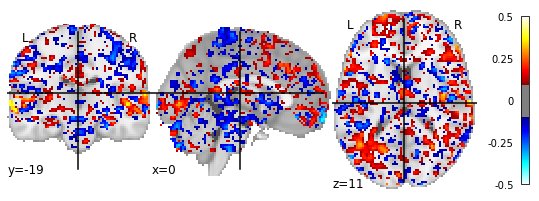

In [43]:
from nilearn.image import mean_img
mean_scores = mean_img('output/sub-24/sub-24_task-alice_scores.nii.gz')

from nilearn import plotting
plotting.plot_stat_map(mean_scores, threshold=0.1)
plotting.show()